<h1><center>Analyzation of Current Mammography Coverage to Help Direct FDA Funds</center></h1>

# Introduction

Breast cancer is a serious illness that impacts over 250,000 women per year in the United States. It is the second most common cancer and the second leading cause of cancer-related deaths in women. Mammograms are an essential medical tool that aids in detecting breast cancer. Detecting cancer early ensures the best chances of full recovery. By having access to Mammography centers, women have better resources available to help catch breast cancer before it spreads.

We were given a dataset of every Mammography center in the United States, and the data from the 2010 Census, which extrapolates population predictions up to 2019. Our goal is to use both of these datasets to find holes in current Mammography coverage, and to provide recommendations of how/where the FDA should allocate its funds, to ensure areas lacking coverage can get the financial support they need to change this. 


***Our Mission:***
- Analyze the data to discover areas/states lacking in current Mammography coverage
- To provide the FDA with data-backed recommendations of how they should allocate their funds

In [2128]:
import pandas as pd
import numpy as np
import matplotlib as plt
import seaborn
import math
from operator import itemgetter
import statsmodels.api as sm

%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
plt.rcParams["patch.force_edgecolor"] = True

In [2129]:
#Inserting our cleaned FDA data set with our columns back in the correct allignment
fda = pd.read_csv("clean_fda.csv")
census = pd.read_csv("census.csv")
census

,SUMLEV,REGION,DIVISION,STATE,NAME,SEX,AGE,ESTBASE2010_CIV,POPEST2010_CIV,POPEST2011_CIV,POPEST2012_CIV,POPEST2013_CIV,POPEST2014_CIV,POPEST2015_CIV,POPEST2016_CIV,POPEST2017_CIV,POPEST2018_CIV,POPEST2019_CIV
0,10,0,0,0,United States,0,0,3944160,3951430,3963092,3926570,3931258,3954787,3983981,3954773,3893990,3815343,3783052
1,10,0,0,0,United States,0,1,3978090,3957730,3966225,3977549,3942698,3948891,3973133,4002903,3972711,3908830,3829599
2,10,0,0,0,United States,0,2,4096939,4090621,3970654,3978925,3991740,3958711,3966321,3991349,4020045,3987032,3922044
3,10,0,0,0,United States,0,3,4119051,4111688,4101644,3981531,3991017,4005928,3974351,3982984,4006946,4033038,3998665
4,10,0,0,0,United States,0,4,4063186,4077346,4121488,4111490,3992502,4004032,4020292,3989750,3997280,4018719,4043323
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13567,40,4,8,56,Wyoming,2,82,1103,1103,1107,1084,1106,1105,1037,1091,1126,1110,1166
13568,40,4,8,56,Wyoming,2,83,911,936,1028,1035,1002,1030,1031,954,1024,1047,1036
13569,40,4,8,56,Wyoming,2,84,894,883,880,1011,988,945,973,974,916,984,1006
13570,40,4,8,56,Wyoming,2,85,5624,5646,5731,5849,6042,6250,6371,6543,6741,6801,6863


In [2130]:
#Dropping unneeded columns
fda.drop(['Unnamed: 0','Phone', 'Fax', 'Unnamed: 9', 'Unnamed: 10', 'Unnamed: 11', 'Unnamed: 12'], axis = 1, inplace = True)
fda

,Facility Name,Address 1,Address 2,Address 3,City,State,Zip Code
0,31 Medical Group Aviano AB,Italy,31 Medical Group,Unit 6180,Air Post Office,AE,9604
1,Landstuhl Regional Medical Center,CMR 402,MCEUL-R,NaN,APO,AE,09180-3460
2,48th Medical Group 48 MSGS/SGCR,Unit 5115,48 MSGS/SGCR,NaN,APO,AE,09461-5115
3,U.S. Naval Hospital - Naples,Italy,PSC 808 BOX 19,NaN,FPO,AE,9618
4,U.S. Naval Hospital - Sigonella [Italy],PSC 836 Box 2670,NaN,NaN,FPO,AE,09636-2670
...,...,...,...,...,...,...,...
8806,Memorial Hospital of Carbon County,2221 W Elm St,NaN,NaN,Rawlins,WY,82301
8807,Memorial Hospital of Converse County,111 South 5th Street,NaN,NaN,Douglas,WY,82633
8808,Campbell County Memorial Hospital,501 S. Burma Ave,NaN,NaN,Gillette,WY,82716
8809,Cheyenne Rad Grp dba Cheyenne Women's Imaging ...,5050 Powderhouse Road,NaN,NaN,Cheyenne,WY,82009


In [2131]:
#The CDC reccomends women to begin mammography screening at 45 (no earlier than 40) years old, up until 75 years
#old as most women are at risk of breast cancer from 50-74.

number_facility = 8811
censusw = census[census['SEX'] == 2]
at_risk_women = censusw[(censusw['SUMLEV'] == 10) & (censusw['AGE'] >= 40) & (censusw['AGE'] <= 74)]['POPEST2019_CIV'].sum()
'There are an estimated '+ '{:,}'.format(at_risk_women) +' Women between 40 and 74 years old as of 2019.'

'There are an estimated 69,429,768 Women between 40 and 74 years old as of 2019.'

In [2132]:
#Finding the amount of total facilities in our dataset and using that to divide the number of women in the
#age range above

woman_per_facilities = at_risk_women / number_facility
'At a national level, each mammogram facility serves '+ '{:,}'.format(int(woman_per_facilities.round())) +' woman on average'

'At a national level, each mammogram facility serves 7,880 woman on average'

In [2133]:
#Dictionaries between states and abbreviations to help us better connect the Cencus and the FDA dataframes

states_map = {
    'AK': 'Alaska',
    'AL': 'Alabama',
    'AR': 'Arkansas',
    'AZ': 'Arizona',
    'CA': 'California',
    'CO': 'Colorado',
    'CT': 'Connecticut',
    'DC': 'District of Columbia',
    'DE': 'Delaware',
    'FL': 'Florida',
    'GA': 'Georgia',
    'HI': 'Hawaii',
    'IA': 'Iowa',
    'ID': 'Idaho',
    'IL': 'Illinois',
    'IN': 'Indiana',
    'KS': 'Kansas',
    'KY': 'Kentucky',
    'LA': 'Louisiana',
    'MA': 'Massachusetts',
    'MD': 'Maryland',
    'ME': 'Maine',
    'MI': 'Michigan',
    'MN': 'Minnesota',
    'MO': 'Missouri',
    'MS': 'Mississippi',
    'MT': 'Montana',
    'NC': 'North Carolina',
    'ND': 'North Dakota',
    'NE': 'Nebraska',
    'NH': 'New Hampshire',
    'NJ': 'New Jersey',
    'NM': 'New Mexico',
    'NV': 'Nevada',
    'NY': 'New York',
    'OH': 'Ohio',
    'OK': 'Oklahoma',
    'OR': 'Oregon',
    'PA': 'Pennsylvania',
    'RI': 'Rhode Island',
    'SC': 'South Carolina',
    'SD': 'South Dakota',
    'TN': 'Tennessee',
    'TX': 'Texas',
    'UT': 'Utah',
    'VA': 'Virginia',
    'VT': 'Vermont',
    'WA': 'Washington',
    'WI': 'Wisconsin',
    'WV': 'West Virginia',
    'WY': 'Wyoming',
    'US': 'United States'
}

list_states = [ 'AK', 'AL', 'AR', 'AZ', 'CA', 'CO', 'CT', 'DC', 'DE', 'FL', 'GA',
           'HI', 'IA', 'ID', 'IL', 'IN', 'KS', 'KY', 'LA', 'MA', 'MD', 'ME',
           'MI', 'MN', 'MO', 'MS', 'MT', 'NC', 'ND', 'NE', 'NH', 'NJ', 'NM',
           'NV', 'NY', 'OH', 'OK', 'OR', 'PA', 'RI', 'SC', 'SD', 'TN', 'TX',
           'UT', 'VA', 'VT', 'WA', 'WI', 'WV', 'WY']
    
#Retrieved from https://gist.github.com/JeffPaine/3083347

In [2134]:
#Creating a function that calculates the ratio between at-risk-women and facilities available for each state

def state_woman_per(state):
    """
    Inputs: State, a 2 character abbreviation for every state/territory in the fda dataframe
    Output: A double representing the at risk population of woman per amount of mammogram facilities, 
    and an integer representing the number of at risk women
    """
    num_facilities = fda[fda['State'] == state].shape[0]
    num_risk_women = censusw[(censusw['NAME'] == states_map[state]) & (censusw['AGE'] >= 40) & (censusw['AGE'] <= 74)]['POPEST2019_CIV'].sum()

    return (num_risk_women / num_facilities), num_risk_women

In [2135]:
#Creating a dataframe that plots state, number of at risk women, and women per facility

women_map = {}

for state in list_states:
    woman_per = state_woman_per(state)[0]
    women_map[state] = woman_per
        

women_map['US'] = woman_per_facilities
    
women_facility_df = pd.DataFrame(women_map.items(), columns=['State', 'Women Per Facility'])
women_facility_df.sort_values(by = 'State', inplace = True, ascending = False)

women_map = {}
for state in list_states:
    woman_in = state_woman_per(state)[1]
    women_map[state] = woman_in

    
women_map['US'] =at_risk_women

women_pop_df = pd.DataFrame(women_map.items(), columns=['State2', 'Number of At Risk Women'])
women_pop_df.sort_values(by = 'State2', inplace = True, ascending = False)


women_state_df = pd.concat([women_facility_df, women_pop_df], axis = 1)
women_state_df.drop(columns = ['State2'], inplace = True)
women_state_df.sort_values(by = 'Women Per Facility', inplace = True, ascending = False)
women_state_df.head(15)

,State,Women Per Facility,Number of At Risk Women
47,WA,10550.449664,1572017
40,SC,10547.763636,1160254
4,CA,10523.499343,8008383
20,MD,10140.825758,1338589
19,MA,9793.754839,1518032
43,TX,9772.702091,5609531
46,VT,9656.600000,144849
32,NM,9588.869565,441088
33,NV,9334.376812,644072
45,VA,8938.897561,1832474


/var/folders/8q/rjmd941n23l2prx2gffgpgmw0000gn/T/ipykernel_23600/428905388.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  women_facility_plot.sort_values(by='Women Per Facility', inplace = True, ascending = False)


<AxesSubplot:title={'center':'Women Per Mammogram Facility'}, xlabel='State'>

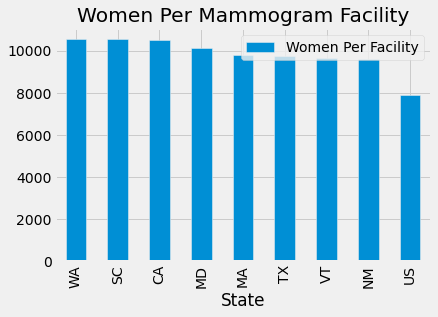

In [2136]:
#We decided to compare some of the states with the highest women per facility with the average in the nation,
#this gives us a chart of the states most in need of more mammography centers

women_facility_plot = women_facility_df[(women_facility_df['Women Per Facility'] > 9500) | (women_facility_df['State'] == 'US')]
women_facility_plot.sort_values(by='Women Per Facility', inplace = True, ascending = False)

women_facility_plot.plot(kind='bar', x='State', y='Women Per Facility', title='Women Per Mammogram Facility')

/var/folders/8q/rjmd941n23l2prx2gffgpgmw0000gn/T/ipykernel_23600/1119949080.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  women_facility_plot2 = women_state_df[(women_facility_df['State'] != 'US')]


<AxesSubplot:title={'center':'Relationship Between Number of At Risk Women and Women per Facility'}, xlabel='Number of At Risk Women', ylabel='Women Per Facility'>

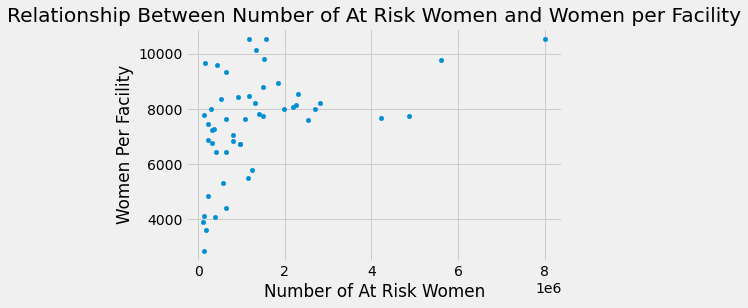

In [2137]:
#We plotted the population of at risk women to the women per facility to see if we find any relation between the 
#two variables.
#We found that the two variables do not have a strong positive correlation

women_facility_plot2 = women_state_df[(women_facility_df['State'] != 'US')]
women_facility_plot2.plot(kind = 'scatter', x='Number of At Risk Women', y='Women Per Facility', title = 'Relationship Between Number of At Risk Women and Women per Facility')

In [2138]:
#Loading in additional datasets. We chose to use datasets of zipcodes and their respective
#populations for the top 8 states in women at risk per facility

wa = pd.read_csv('washington.csv')
sc = pd.read_csv('south_carolina.csv')
ca = pd.read_csv('california.csv')
md = pd.read_csv('maryland.csv')
ma = pd.read_csv('massachusetts.csv')
tx = pd.read_csv('texas.csv')
vt = pd.read_csv('vermont.csv')
nm = pd.read_csv('newmexico.csv')

ca = ca.dropna()

wa['Population'] = wa['Population'].str.replace(',','')
wa = wa[wa['Population'].astype('int') >= 1000]

sc['Population'] = sc['Population'].str.replace(',','')
sc = sc[sc['Population'].astype('int') >= 1000]

ca['Population'] = ca['Population'].str.replace(',','')
ca = ca[ca['Population'].astype('int') >= 1000]

md['Population'] = md['Population'].str.replace(',','')
md = md[md['Population'].astype('int') >= 1000]

ma['Population'] = ma['Population'].str.replace(',','')
ma = ma[ma['Population'].astype('int') >= 1000]

tx['Population'] = tx['Population'].str.replace(',','')
tx = tx[tx['Population'].astype('int') >= 1000]

vt['Population'] = vt['Population'].str.replace(',','')
vt = vt[vt['Population'].astype('int') >= 1000]

nm['Population'] = nm['Population'].str.replace(',','')
nm = nm[nm['Population'].astype('int') >= 1000]

In [2139]:
#Mapping the states dataframes to abbreviations for later use

states_df_map = {
    'WA': wa,
    'SC': sc,
    'CA': ca,
    'MD': md,
    'MA': ma,
    'TX': tx,
    'VT': vt,
    'NM': nm 
}

In [2140]:
#Since our datasets related zipcode to general population, we found the percentage of 
#national women-at-risk to national population, and multiplied every population by that percentage to give us an
#estimate of women-at-risk populations per zipcode

def estimate_at_risk_women(state):
    """
    Inputs: State, a 2 character abbreviation for every state/territory in the fda dataframe
    
    This function adds a new column to every inputted state dataframe to estimate the number of at risk women,
    based off of the census data
    """
    
    at_risk_women = censusw[(censusw['NAME'] == states_map[state]) & (censusw['AGE'] >= 40) & (censusw['AGE'] <= 74)]['POPEST2019_CIV'].sum()
    total_pop = census[(census['NAME'] == states_map[state]) & (census['AGE'] == 999) & (census['SEX'] == 0)]['POPEST2019_CIV'].sum()
    
    percentage = at_risk_women / total_pop

    
    states_df_map[state]['Estimated At Risk Women'] = (states_df_map[state]['Population'].astype(float) * percentage).astype(int)

for key in states_df_map:
    estimate_at_risk_women(key)

#Copying these dataframes to use later
washington = wa
southcar = sc
cali = ca
maryland = md
mass = ma
texas = tx
vermont = vt
newmex = nm


#Addiing a state column for easy comparison when we merge these dataframes
washington['State'] = 'WA'
southcar['State'] = 'SC'
cali['State'] = 'CA'
maryland['State'] = 'MD'
mass['State'] = 'MA'
texas['State'] = 'TX'
vermont['State'] = 'VT'
newmex['State'] = 'NM'

In [2141]:
#Combining the 8 states individual dataframes into one

fda_top8 = pd.DataFrame()
for key in states_df_map: 
    temp_df = fda[fda['State'] == key]
    
    fda_top8 = pd.concat([fda_top8, temp_df])

In [2142]:
#This function truncates zipcodes, getting rid of the additional numbers that follow the '-'
#This function also creates a new column that counts the number of facilities for every zipcode

def num_facilities(state):
    """
    Inputs: State, a 2 character abbreviation for every state/territory in the fda dataframe
    
    This function adds a new column to every inputted state dataframe representing 
    the number of facilities in each zipcode
    """
    
    state_fda = fda_top8[fda_top8['State'] == state]
    bad_zip = state_fda[state_fda['Zip Code'].str.contains('-')]
    
    for row in range(bad_zip.shape[0]):
        bad_zip.iloc[row][6] = bad_zip.iloc[row][6][:5]
    
    state_fda = state_fda[state_fda['Zip Code'].apply(lambda x: len(str(x)) < 10)]
    state_fda = pd.concat([state_fda, bad_zip])
    
    state_fda['Zip Code'] = state_fda['Zip Code'].astype('int')
    states_df_map[state]['Zip Code'] = states_df_map[state]['Zip Code'].astype('int')
    
    
    facilities_in_zip = (state_fda.groupby('Zip Code').count())[['State']]
    
    final = pd.merge(facilities_in_zip, states_df_map[state], on='Zip Code') 
    
    final.rename(columns={"State_x": "Number of Facilities"}, inplace = True)
    final.rename(columns={"State_y": "State"}, inplace = True)
    
    return final

In [2143]:
#Running the function on each individual dataset
wa = num_facilities('WA')
sc = num_facilities('SC')
ca = num_facilities('CA')
md = num_facilities('MD')
ma = num_facilities('MA')
tx = num_facilities('TX')
vt = num_facilities('VT')
nm = num_facilities('NM')
wa

,Zip Code,Number of Facilities,Rank,Population,Estimated At Risk Women,State
0,98002,1,65,35915,7465,WA
1,98003,3,18,50501,10497,WA
2,98004,7,52,38632,8030,WA
3,98012,1,3,75045,15599,WA
4,98021,1,74,34359,7142,WA
...,...,...,...,...,...,...
100,99344,2,177,19198,3990,WA
101,99350,1,205,14101,2931,WA
102,99352,1,70,34772,7227,WA
103,99362,2,34,42706,8877,WA


In [2144]:
#Calculating the women at risk per facility for each state, dropping unnecessary columns

wa['Estimated At Risk Women Per Facility'] = (wa['Estimated At Risk Women'] / wa['Number of Facilities']).astype(int)
sc['Estimated At Risk Women Per Facility'] = (sc['Estimated At Risk Women'] / sc['Number of Facilities']).astype(int)
ca['Estimated At Risk Women Per Facility'] = (ca['Estimated At Risk Women'] / ca['Number of Facilities']).astype(int)
md['Estimated At Risk Women Per Facility'] = (md['Estimated At Risk Women'] / md['Number of Facilities']).astype(int)
ma['Estimated At Risk Women Per Facility'] = (ma['Estimated At Risk Women'] / ma['Number of Facilities']).astype(int)
tx['Estimated At Risk Women Per Facility'] = (tx['Estimated At Risk Women'] / tx['Number of Facilities']).astype(int)
vt['Estimated At Risk Women Per Facility'] = (vt['Estimated At Risk Women'] / vt['Number of Facilities']).astype(int)
nm['Estimated At Risk Women Per Facility'] = (nm['Estimated At Risk Women'] / nm['Number of Facilities']).astype(int)

wa.sort_values(by = 'Estimated At Risk Women Per Facility', inplace = True, ascending = False)
sc.sort_values(by = 'Estimated At Risk Women Per Facility', inplace = True, ascending = False)
ca.sort_values(by = 'Estimated At Risk Women Per Facility', inplace = True, ascending = False)
md.sort_values(by = 'Estimated At Risk Women Per Facility', inplace = True, ascending = False)
ma.sort_values(by = 'Estimated At Risk Women Per Facility', inplace = True, ascending = False)
tx.sort_values(by = 'Estimated At Risk Women Per Facility', inplace = True, ascending = False)
vt.sort_values(by = 'Estimated At Risk Women Per Facility', inplace = True, ascending = False)
nm.sort_values(by = 'Estimated At Risk Women Per Facility', inplace = True, ascending = False)


wa.drop(['Rank'], axis=1, inplace = True)
sc.drop(['Rank'], axis=1, inplace = True)
ca.drop(['Rank'], axis=1, inplace = True)
md.drop(['Rank'], axis=1, inplace = True)
ma.drop(['Rank'], axis=1, inplace = True)
tx.drop(['Rank'], axis=1, inplace = True)
vt.drop(['Rank'], axis=1, inplace = True)
nm.drop(['Rank'], axis=1, inplace = True)

wa['State'] = 'WA'
sc['State'] = 'SC'
ca['State'] = 'CA'
md['State'] = 'MD'
ma['State'] = 'MA'
tx['State'] = 'TX'
vt['State'] = 'VT'
nm['State'] = 'NM'

In [2145]:
#Now, we are looking at estimated at risk women per facility for every zipcode that has at least one facility

eight_states = pd.concat([wa, sc, ca, md, ma, tx, vt, nm])
eight_states.sort_values(by = 'Estimated At Risk Women Per Facility', inplace = True, ascending = False)
eight_states.drop(columns = 'Population', inplace = True)
eight_states.head(15)

,Zip Code,Number of Facilities,Estimated At Risk Women,State,Estimated At Risk Women Per Facility
298,78660,1,21475,TX,21475
168,77084,1,20950,TX,20950
334,94565,1,20490,CA,20490
162,92335,1,19810,CA,19810
58,90805,1,19705,CA,19705
24,90201,1,19657,CA,19657
73,91342,1,18876,CA,18876
13,75052,1,18596,TX,18596
113,91911,1,18026,CA,18026
163,92345,1,17905,CA,17905


In [2146]:
#Now we must look at number of at risk women for zipcodes that do not have a facility

#We are truncating the long zip codes again
bad_zip = fda_top8[fda_top8['Zip Code'].str.contains('-')]
    
for row in range(bad_zip.shape[0]):
    bad_zip.iloc[row][6] = bad_zip.iloc[row][6][:5]
    
fda_top8 = fda_top8[fda_top8['Zip Code'].apply(lambda x: len(str(x)) < 10)]
fda_top8 = pd.concat([fda_top8, bad_zip])
    
fda_top8['Zip Code'] = fda_top8['Zip Code'].astype('int')

In [2147]:
no_facilities_zip = pd.concat([washington, southcar, cali, maryland, mass, texas, vermont, newmex])
no_facilities_zip.dropna(inplace = True)
no_facilities_zip['Zip Code'] = no_facilities_zip['Zip Code'].astype('int')

In [2148]:
#We are comparing our zipcode dataset with the facilities dataset to remove any row from the zipcodes that are also
#In the facilities data set, ensuring we are left with a dataset of zipcodes that do not appear in the mammography
#coverage dataset

condition = no_facilities_zip['Zip Code'].isin(fda_top8['Zip Code'])
no_facilities_zip.drop(no_facilities_zip[condition].index, inplace = True)
no_facilities_zip.drop(columns = ['Rank'], inplace = True)


no_facilities_zip.sort_values(by = 'Estimated At Risk Women', ascending = False, inplace = True)
no_facilities_zip.head(15)

,Zip Code,Population,Estimated At Risk Women,State
59,95123,71118,14471,CA
59,77077,63168,12268,TX
164,92117,55195,11231,CA
175,91344,54465,11082,CA
186,94539,53762,10939,CA
187,92129,53742,10935,CA
193,92078,53247,10834,CA
194,92833,53188,10822,CA
203,92544,52364,10655,CA
209,92234,51836,10547,CA


In [2149]:
#Want to plot num zipcodes w/ no facilities per the 8 states

zipcodes_df = pd.concat([washington, southcar, cali, maryland, mass, texas, vermont, newmex])
zipcode_no_count = no_facilities_zip.groupby(['State']).count()

#zipcode_no_count['Number of Zip Codes Lacking Facilities'] = no_facilities_zip.groupby(['State']).count()
zipcode_no_count.drop(columns = ['Population', 'Estimated At Risk Women'], inplace = True)
zipcode_no_count.rename(columns ={'Zip Code': 'Amount Zip Codes With Facilities'}, inplace = True)


zipcodes_proportions = zipcodes_df.groupby(['State']).count()
zipcodes_proportions.drop(columns = ['Rank','Population', 'Estimated At Risk Women'], inplace = True)
zipcodes_proportions.rename(columns = {'Zip Code': 'Total Zip Codes'}, inplace = True)

zipcodes_proportions = pd.concat([zipcodes_proportions, zipcode_no_count], axis = 1)
zipcodes_proportions['Proportion Zip Codes No Facilities to Total Zip Codes'] = zipcodes_proportions['Amount Zip Codes With Facilities'] / zipcodes_proportions['Total Zip Codes']

df2 = pd.DataFrame([[zipcodes_df.shape[0],eight_states.shape[0],(eight_states.shape[0] / zipcodes_df.shape[0])]], columns=['Total Zip Codes','Amount Zip Codes With Facilities','Proportion Zip Codes No Facilities to Total Zip Codes'])
zipcodes_proportions = pd.concat([zipcodes_proportions, df2])


zipcodes_proportions.rename(index={0:'US'},inplace = True)

zipcodes_proportions.sort_values(by = 'Proportion Zip Codes No Facilities to Total Zip Codes', inplace = True, ascending = False)

zipcodes_proportions


,Total Zip Codes,Amount Zip Codes With Facilities,Proportion Zip Codes No Facilities to Total Zip Codes
TX,1473,765,0.519348
CA,1426,718,0.503506
US,4807,1258,0.261702
MA,467,76,0.162741
WA,425,59,0.138824
SC,352,42,0.119318
MD,348,40,0.114943
NM,180,3,0.016667
VT,136,1,0.007353


<AxesSubplot:title={'center':'Proportion of Total Zip Codes to Zip Codes with No Facilities'}>

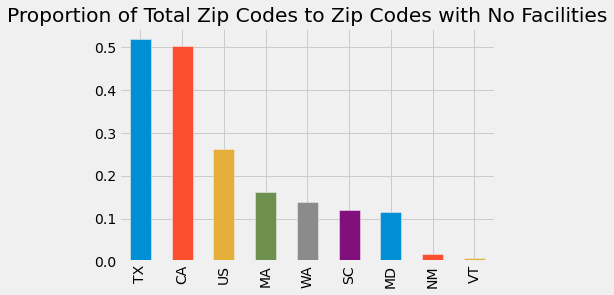

In [2150]:
zipcodes_proportions.plot(kind='bar', color=['C0', 'C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7', 'C8', 'C9'], y='Proportion Zip Codes No Facilities to Total Zip Codes', use_index = True, legend = False, title='Proportion of Total Zip Codes to Zip Codes with No Facilities')

***Predicting the Future***

In [2151]:
#Using Census data extrapolated from December 2018 to predict future populations
future_2023 = pd.read_csv("NationalProjections_ProjectedTotalPopulation_2020-2040_Updated12-2018.csv") 
future_2023.rename(columns = {'Unnamed: 1': 'State', 'Unnamed: 2': '2010', 'Unnamed: 3': '2020', 
                              'Unnamed: 4': '2030','Unnamed: 5': '2040'}, inplace = True)
future_2023.drop(columns = ['Observed and Total Population for the U.S. and the States, 2010-2040', '2010', '2020', '2040'], inplace = True)
future_2023 = future_2023.dropna()

future_2023['2030'] = future_2023['2030'].str.replace(',','')
future_2023.head(15)

,State,2030
3,United States,357975719
4,Alabama,5029833
5,Alaska,792188
6,Arizona,8238407
7,Arkansas,3155798
8,California,43751116
9,Colorado,6766983
10,Connecticut,3601202
11,Delaware,1082192
12,District of Columbia,888891


In [2152]:
#Setting up an empty data frame to add onto

percentage_dict = {'State':[], 'Percentage of at-risk-women': []}
percentage_df = pd.DataFrame.from_dict(percentage_dict)

In [2153]:
#Creating a dataframe that shows the percentages of at-risk-women per state and multiplying that by 2030 estimated 
#population

def generate_percentage(state):
    """
    Inputs: State, the capitalized name for each state. (Ex: Arizona)
    
    This function adds a new column to every inputted state dataframe to estimate the number of at risk women,
    based off of the census data
    """
    
    at_risk_women = censusw[(censusw['NAME'] == state) & (censusw['AGE'] >= 40) & (censusw['AGE'] <= 74)]['POPEST2019_CIV'].sum()
    total_pop = census[(census['NAME'] == state) & (census['AGE'] == 999) & (census['SEX'] == 0)]['POPEST2019_CIV'].sum()
    
    percentage = at_risk_women / total_pop
    
    temp_dict = {'State':[state], 'Percentage of at-risk-women': [percentage]}
    temp_df = pd.DataFrame.from_dict(temp_dict)
    
    return temp_df


for value in states_map.values():
    percentage_df = pd.concat([percentage_df, generate_percentage(value)])

percentage_df = pd.merge(percentage_df, future_2023, on='State')
percentage_df['Estimated At Risk Women'] = (percentage_df['2030'].astype(float) * percentage_df['Percentage of at-risk-women'].astype(float)).astype('int')
percentage_df.drop(columns = ['Percentage of at-risk-women', '2030'],inplace = True)

In [2154]:
#Dividing estimated at risk women in 2030 by current facilities

def woman_per_2030(state):
    """
    Inputs: State, 2 character abbreviation
    Output: 
    """
    if state == 'US':
        num_facilities = 8811
    else:
        num_facilities = fda[fda['State'] == state].shape[0]
    num_risk_women = percentage_df[percentage_df['State'] == states_map[state]].iloc[0][1]
    
    temp_dict = {'State':[state], 'At Risk Women (2023) Per Current Facility': [(num_risk_women / num_facilities)]}
    temp_df = pd.DataFrame.from_dict(temp_dict)
    
    
    return temp_df

women_2030 = {'State':[], 'At Risk Women (2023) Per Current Facility': []}
women_2030_df = pd.DataFrame.from_dict(women_2030)

for key in states_map:
    women_2030_df = pd.concat([women_2030_df, woman_per_2030(key)])
    
women_2030_df['At Risk Women (2023) Per Current Facility'] = women_2030_df['At Risk Women (2023) Per Current Facility'].astype('int')
women_2030_df.sort_values(by = 'At Risk Women (2023) Per Current Facility', ascending = False, inplace = True)
women_2030_df.head(15)

,State,At Risk Women (2023) Per Current Facility
0,WA,12201
0,SC,11962
0,TX,11754
0,CA,11698
0,MD,11056
0,NV,10921
0,MA,10552
0,CO,9994
0,AZ,9980
0,VA,9906


# Initial Conclusions

From our analysis of the data, we discovered a lack of mammography coverage in a few states.

# Countrywide Analysis

Looking at each state in the country, we managed to find the number of at- risk-women, and the number of facilities, to calculate the number of women per facility. From this, we were able to conclude that the higher the at-risk-women per facility, the more women each facility serves. We can use this information to deduce that the states with the highest woman per facility may deserve the bulk of the FDA funds, to invest in creating new mammography centers.

We defined at-risk-women as women that fall in between the age range of 40-74. We got these numbers from the [CDC](https://www.cdc.gov/cancer/breast/basic_info/screening.htm#:~:text=Breast%20Cancer%20Screening%20Recommendations&text=The%20USPSTF%20recommends%20that%20women,often%20to%20get%20a%20mammogram), as they recommended women start taking mammograms at age 45 (no earlier than 40), and that women most often get diagnosed with breast cancer between 50-74 years of age.

We plotted the eight states with the highest at-risk-women per facility ratio as well as the national woman-per-facility ratio to discover a large discrepancy between the states and the national average.

In [2155]:
women_state_df.head(15)

,State,Women Per Facility,Number of At Risk Women
47,WA,10550.449664,1572017
40,SC,10547.763636,1160254
4,CA,10523.499343,8008383
20,MD,10140.825758,1338589
19,MA,9793.754839,1518032
43,TX,9772.702091,5609531
46,VT,9656.600000,144849
32,NM,9588.869565,441088
33,NV,9334.376812,644072
45,VA,8938.897561,1832474


<AxesSubplot:title={'center':'Women Per Mammogram Facility'}, xlabel='State'>

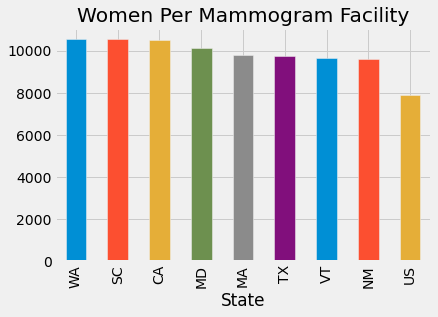

In [2156]:
women_facility_plot.plot(kind='bar', x='State', y='Women Per Facility', legend = False, title='Women Per Mammogram Facility', color = ['C0', 'C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7', 'C8'])

# Analyzing the Top States

Using the trends we discovered on a national level, we honed into our data on a smaller scale. Choosing the eight states with the highest at-risk-women per facility, we brought in extra data sets with zip codes and their respective populations. Using our census data, we estimated the at-risk-women population in each zip code. After this, we then created two dataframes. One looked at at-risk-women per facility on a zip code level, and the other looked at the number of at-risk-women in zipcodes with no facilities.

**At-Risk-Women Per Facility:**

In [2157]:
eight_states.head(15)

,Zip Code,Number of Facilities,Estimated At Risk Women,State,Estimated At Risk Women Per Facility
298,78660,1,21475,TX,21475
168,77084,1,20950,TX,20950
334,94565,1,20490,CA,20490
162,92335,1,19810,CA,19810
58,90805,1,19705,CA,19705
24,90201,1,19657,CA,19657
73,91342,1,18876,CA,18876
13,75052,1,18596,TX,18596
113,91911,1,18026,CA,18026
163,92345,1,17905,CA,17905


**Amount At-Risk-Women In Zip Codes with no Facilities:**

In [2158]:
no_facilities_zip.head(15)

,Zip Code,Population,Estimated At Risk Women,State
59,95123,71118,14471,CA
59,77077,63168,12268,TX
164,92117,55195,11231,CA
175,91344,54465,11082,CA
186,94539,53762,10939,CA
187,92129,53742,10935,CA
193,92078,53247,10834,CA
194,92833,53188,10822,CA
203,92544,52364,10655,CA
209,92234,51836,10547,CA


**Diving Deeper:**

We noticed that in both dataframes, California and Texas are heavily overrepresented in the top 8 states. This was somewhat surprising considering Washington held the name for the state with the highest at-risk-women-to-facility ratio. 

We came up with a few possible explanations for this phenomenon. Densely populated states like California and Texas have significantly more zip codes than less densely populated states like Washington. To chart these differences, we created another dataframe that shows the percentage of a state's zip codes that do not have a mammography facility. We then charted this with a bar graph.

In [2159]:
zipcodes_proportions

,Total Zip Codes,Amount Zip Codes With Facilities,Proportion Zip Codes No Facilities to Total Zip Codes
TX,1473,765,0.519348
CA,1426,718,0.503506
US,4807,1258,0.261702
MA,467,76,0.162741
WA,425,59,0.138824
SC,352,42,0.119318
MD,348,40,0.114943
NM,180,3,0.016667
VT,136,1,0.007353


<AxesSubplot:title={'center':'Proportion of Total Zip Codes to Zip Codes with No Facilities'}>

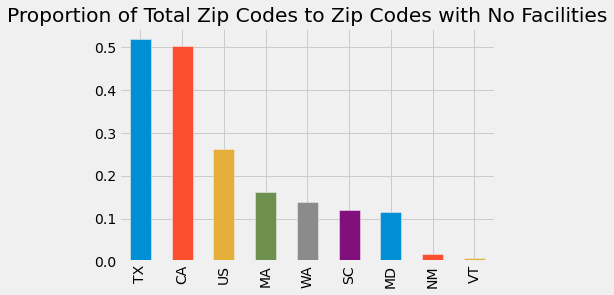

In [2160]:
zipcodes_proportions.plot(kind='bar', color=['C0', 'C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7', 'C8', 'C9'], y='Proportion Zip Codes No Facilities to Total Zip Codes', use_index = True, legend = False, title='Proportion of Total Zip Codes to Zip Codes with No Facilities')

From this plot and dataframe, we can see that Texas and California have a significantly higher percentage of zipcodes that are missing mammography centers. Out of our eight highest at-risk-women per facility states, only Texas and California surpass the national percentage of total zip codes with no facilities.

# Final Reccomendations

From our analysis of the data, we discovered a lack of mammography coverage in a few states. States like **Washington**, **South Carolina**, and **California** lead the nation in the least amount of mammography centers per at-risk-women. 

Looking at the zip codes, we concluded that **California** and **Texas** are heavily overrepresented in the zip codes with the least amount of mammography centers per at-risk-women and in the zip codes with the most at-risk-women with no mammography centers. Extrapolating the zip codes to their respective cities, cities like ***Pflugerville*** (Texas), Parts of ***Houston*** (Texas), ***Pittsburg*** (California), and ***Fontana*** (California) have only one certified mammography for about **20,000 at-risk-women**.

Parts of cities like ***San Jose*** (California), parts of ***Houston*** (Texas), ***San Diego*** (California), and ***Los Angeles*** (California) have over **11,000 at-risk-women** and no mammography centers.

**Suggestions:**

We have two routes the FDA should choose between. 
1. **Prioritizing less population-dense states to send the funds to.**
    - States like **Washington**, **New Mexico**, and **Vermont** lead the nation in the least amount of mammography facilities per at-risk-women. 
    - However, these states do not have zip codes that lead the nation in the least amount of mammography facilities per at-risk-women. 
    - This could be because these states have a significantly less amount of zip codes. This means that geographically, each zip code range is larger.
    - If each zip code range is larger, and they lead the nation in the least amount of mammography facilities per at-risk-women, the average at-risk-woman is much farther away from a certified mammography facility than in other states.
2. **Prioritizing high population density states to send thier funds to.**
    - States like **Texas** and **California** fall into the leading eight states in the least amount of mammography facilities per at-risk-women. However, California is only third, and Texas barely scratches the top 8.
    - But, these states claim a vast majority of the zip codes with the least amount of mammography facilities per at-risk-women, and a vast majority of the zip codes with the most at-risk-women with no mammography facilities.
    - Therefore, mammography centers may be closer to each at-risk-women, but each center has to serve a far greater number of individuals, so significant waits/delays may impact the availability for each at-risk-woman.
    
Both of these choices would significantly help at-risk-women's accessibility to mammography centers and early breast cancer identification. A combination of these two choices might be the best of both worlds. Expanding the number of mammography centers in highly populated areas (cities in California and Texas) can help reduce the waitlist of these facilities, and sending the funds to less population-dense areas (states like Vermont, South Carolina, and New Mexico) can help create new mammography centers which reduce the distance at-risk-women would have to travel for breast cancer detection.

# Future Issues

We brought in a data set that extrapolated December 2018 Census data to 2030. We used this data, along with the original Census data, to estimate the at-risk-2030-women per current facility to view the states that will have the least amount of facilities (if nothing changes) for 2030 estimated at-risk-women.

In [2161]:
women_2030_df.head(15)

,State,At Risk Women (2023) Per Current Facility
0,WA,12201
0,SC,11962
0,TX,11754
0,CA,11698
0,MD,11056
0,NV,10921
0,MA,10552
0,CO,9994
0,AZ,9980
0,VA,9906


<AxesSubplot:title={'center':'Estimated At Risk Women (in 2030) Per Current Mammography Facilities'}, xlabel='State'>

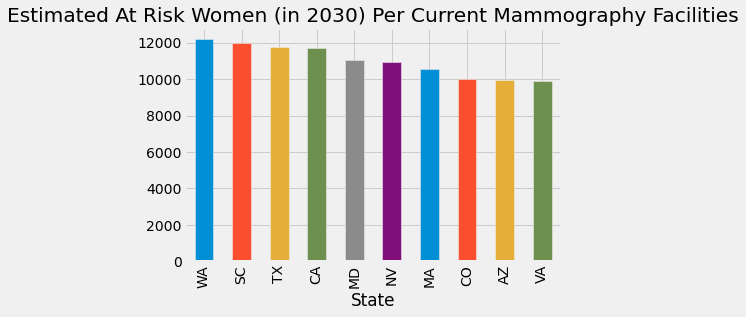

In [2162]:
women_2030_df.head(10).plot(kind='bar', color=['C0', 'C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7', 'C8', 'C9'], y='At Risk Women (2023) Per Current Facility', x = 'State', legend = False, title='Estimated At Risk Women (in 2030) Per Current Mammography Facilities')

***Future Data Reinforcing our Reccomendation***

According to this data, similar states to before like **Washington**, **South Carolina**, and **Texas**, will continue to lead the nation in the least amount of mammography centers per at-risk-woman in 2030 if the FDA does not follow our recommendations. Also, states like **Nevada** and **Colorado** have jumped up the rankings a significant amount, therefore these states may require some of the current FDA grants to ensure they will not lead the nation in the least amount of mammography centers per at-risk-woman in the future.